In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.externals import joblib
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../data/Processed/train.csv')
X_train = train.loc[:,[c for c in train.columns if c != 'patient_id']]
y_train = pd.read_csv('../data/raw/train_labels.csv', usecols=['heart_disease_present'])
test = pd.read_csv('../data/Processed/test.csv')
X_test = test.loc[:,[c for c in test.columns if c != 'patient_id']]

In [5]:
params = {'max_depth': [5],
          'metric': ['binary_logloss'],
          'n_estimators': [500],
          'eta': np.arange(0.01, 0.1, 0.01),
          'colsample_bytree':np.arange(0.1, 1.1, 0.1),
          'n_jobs': [1],
          'seed': [42],
          'gamma': np.arange(0, 0.9, 0.1),
          'max_bin': np.arange(2, 128, 2),
          'objective': ['binary:logistic'],
          'gamma':np.arange(0, 10, 0.1),
          'alpha':np.arange(0, 1.1, 0.1),
          'lambda':np.arange(0,1.1, 0.1),
          'max_delta_step':np.arange(0, 11, 1)
         }

xgb_model = xgb.XGBClassifier()

rscv = RandomizedSearchCV(xgb_model,
                          params,
                          verbose=1,
                          random_state=42,
                          scoring='roc_auc',
                          n_iter=60,
                          cv = 5,
                          n_jobs=-1)

In [6]:
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.6s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=60, n_jobs=-1,
          param_distributions={'max_depth': [5], 'metric': ['binary_logloss'], 'n_estimators': [500], 'eta': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]), 'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'n_jobs': [1], 'seed': [42], 'gamma': array([0. , 0.1, ...,...5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'max_delta_step': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
          pre_dispatch='2*n_jobs', random_state=42, refit

In [7]:
print(rscv.best_params_,'\n')
print(rscv.best_score_)

{'seed': 42, 'objective': 'binary:logistic', 'n_jobs': 1, 'n_estimators': 500, 'metric': 'binary_logloss', 'max_depth': 5, 'max_delta_step': 9, 'max_bin': 56, 'lambda': 0.4, 'gamma': 2.0, 'eta': 0.01, 'colsample_bytree': 0.1, 'alpha': 0.7000000000000001} 

0.9056249999999999


In [8]:
model_name = 'xgb_2'

# params = {'max_depth':5,
#           'metric':'binary_logloss',
#           'n_estimators':5000,
#           'eta':0.4,
#           'colsample_bytree':1,
#           'n_jobs':1,
#           'seed':42,
#           'gamma': 0.1,
#           'max_bin':256,
#           'objective': 'binary:logistic'
#          }

params = rscv.best_params_
xgb_model = xgb.XGBClassifier(**params)

train_ids = X_train.index
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
train_ids = X_train.index
k1 = 5
k2 = 5
skf1 = StratifiedKFold(n_splits=k1, shuffle=True, random_state=42)
skf2 = StratifiedKFold(n_splits=k2, shuffle=True, random_state=42)

In [14]:
counter1 = 1
y_preds = np.zeros(X_test.shape[0])
be = 0
stack = pd.DataFrame()
stack2 = pd.DataFrame()
for train_index, test_index in skf1.split(train_ids, y_train):
    counter2 = 1
    print('Fold k1 {}\n'.format(counter1))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit_ids = X_fit.index
    
    y_preds_stack = np.zeros(X_val.shape[0])
    
    for train_index2, test_index2 in skf2.split(X_fit_ids, y_fit):
        
#         print('Fold k2 {}\n'.format(counter2))
        
        X_fit2, X_val2 = X_fit.iloc[train_index2, :], X_fit.iloc[test_index2, :]
        y_fit2, y_val2 = y_fit.iloc[train_index2], y_fit.iloc[test_index2]

        xgb_model.fit(X_fit2,
                     y_fit2,
                     eval_set=[(X_val2, y_val2)],
                     verbose=0,
                  early_stopping_rounds=50,
                 eval_metric='logloss')

        y_preds += xgb_model.predict_proba(X_test)[:,1]
        y_preds_stack += xgb_model.predict_proba(X_val)[:,1]

        be += xgb_model.best_score
        
        del X_fit2
        del X_val2
        del y_fit2
        del y_val2
        del train_index2
        del test_index2
        gc.collect()

    #     print('Guardamos el modelo')
    #     joblib.dump(lgb_model, '../saved_models/{}_{}.pkl'.format(model_name, counter))

    #     ft_importances += lgb_model.feature_importances_

        counter2 += 1
        
    stack2['patient_id'] = train['patient_id'][test_index].tolist()
    stack2['heart_disease_present'] = y_preds_stack/k2
    stack = pd.concat([stack, stack2], axis = 0)
    
    del X_fit
    del X_val
    del y_fit
    del y_val
    del train_index
    del test_index
    gc.collect()

    counter1 += 1
    
y_preds = y_preds / (k1*k2)

print('\n\nBEST SCORE MEAN:', be / (k1*k2))
stack.to_csv('../stacking/data/train_{}.csv'.format(model_name), index=False)
sub = pd.DataFrame({'patient_id': test['patient_id'], 'heart_disease_present': y_preds})
sub.to_csv('../stacking/data/test_{}.csv'.format(model_name), index=False)

Fold k1 1

Fold k1 2

Fold k1 3

Fold k1 4

Fold k1 5



BEST SCORE MEAN: 0.43291908


In [15]:
stack.head()

,patient_id,heart_disease_present
0,0z64un,0.180913
1,yt1s1x,0.609941
2,3nwy2n,0.861866
3,1r508r,0.155135
4,cvux3j,0.203478


In [62]:
counter = 1
y_preds = np.zeros(X_test.shape[0])
be = 0
stack = pd.DataFrame()
stack2 = pd.DataFrame()
for train_index, test_index in skf.split(train_ids, y_train):
#     print('Fold {}\n'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=0,
                  early_stopping_rounds=50,
                 eval_metric='logloss')

    y_preds += xgb_model.predict_proba(X_test)[:,1]
    stack2['patient_id'] = train['patient_id'][test_index].tolist()
    stack2['heart_disease_present'] = xgb_model.predict_proba(X_val)[:,1]
    stack = pd.concat([stack, stack2], axis = 0)

    be += xgb_model.best_score

    del X_fit
    del X_val
    del y_fit
    del y_val
    del train_index
    del test_index
    gc.collect()

#     print('Guardamos el modelo')
#     joblib.dump(lgb_model, '../saved_models/{}_{}.pkl'.format(model_name, counter))

#     ft_importances += lgb_model.feature_importances_

    counter += 1

y_preds = y_preds / (counter-1)

print('\n\nBEST SCORE MEAN:', be / (counter-1))




BEST SCORE MEAN: 0.40831800000000007


In [55]:
stack.head()

,patient_id,heart_disease_present
0,0z64un,0.081224
1,yt1s1x,0.649749
2,3nwy2n,0.953531
3,1r508r,0.039204
4,cvux3j,0.047122


In [7]:
stack.to_csv('../stacking/data/train_{}.csv'.format(model_name), index=False)

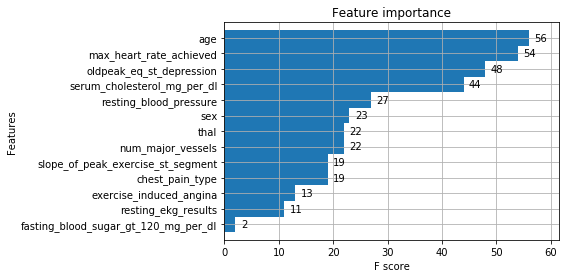

In [65]:
plot_importance(xgb_model, height=1)

In [9]:
y_preds[:5]

array([0.45844439, 0.18401742, 0.82717737, 0.22615613, 0.79762191])

In [63]:
sub = pd.DataFrame({'patient_id': test['patient_id'], 'heart_disease_present': y_preds})

In [64]:
sub.to_csv('../submissions/xgb_4.csv', index=False)